# Sundial Calculations

This notebook accompanies my [sundial paper](https://russellgoyder.github.io/sundial-latex/). I originally used [Maple](https://www.maplesoft.com/) for the calculations, but decided to reproduce them here to make the analysis more accessible, and as away to learn [SymPy](https://www.sympy.org/en/index.html) and [GAlgebra](https://github.com/pygae/galgebra). I used my [cheat sheet](https://russellgoyder.github.io/geometric-algebra-cheat-sheet/) for Geometric Algebra at various points.

I haven't reproduced the orbit analysis, equation of time or plots of the shadow tip yet, but plan to add them in the future. For now, however, all the main results are reproduced here.

In [1]:
import sympy as sp
from sympy import sin, cos, tan
from sympy.abc import *
from galgebra import mv
from galgebra.ga import Ga
from galgebra.printer import latex
from IPython.display import Math

sp.init_printing()

# Multivector mv on its own in a cell appears fine in the notebook but when nbconverted
# to Markdown comes out as \begin{equation*} x \end{equation*} instead of eg $\displaystyle x$
# and consequently isn't rendered in HTML after running mkdocs.
def display(mv):
    return(Math(latex(mv)))

## Setup and Definitions

### Fixed Stars Frame

First, we define the geometric algebra of 3-space and some basis blades from the frame of the "fixed stars"

![Earth's orientation and orbit](https://raw.githubusercontent.com/russellgoyder/sundial-latex/main/figs/MainArena.png?token=GHSAT0AAAAAAB73Q3JM6JGFDMRHPPAJKRQ2ZAWFO7Q "Earth's orientation and orbit.").

In [2]:
coords = sp.symbols('1 2 3', real=True)
G3 = Ga('e', g=[1,1,1], coords=coords)

(e1, e2, e3) = G3.mv()
I = e1^e2^e3

### Earth Frame

Now, let the tilt of the earth's plane (axis) of rotation be $\alpha$ and measure the earth's rotation by $\psi$. Then we can define the Earth frame as follows.

In [4]:
def rotate(mv, angle, bivec):
    rotor = ( cos(angle/2) - (bivec) * sin(angle/2) ).trigsimp()
    return ( rotor * mv * rotor.rev() )

e1_prime = rotate(e1, alpha, e1^e3).trigsimp()

f1 = rotate(e1_prime, psi, e1_prime^e2).trigsimp().trigsimp()
f2 = rotate(e2, psi, e1_prime^e2).trigsimp().trigsimp()
f3 = rotate(e3, alpha, e1^e3).trigsimp().trigsimp()

def print_3frame(frame, symbol):
    return Math(fr'''
            \begin{{align}}
            {symbol}_1 &= {latex(frame[0])} \nonumber \\
            {symbol}_2 &= {latex(frame[1])} \nonumber \\
            {symbol}_3 &= {latex(frame[2])} \nonumber
            \end{{align}}
            ''')

print_3frame((f1,f2,f3), "f")

<IPython.core.display.Math object>

Check that this is an orthonormal frame

In [5]:
result = (e1 ^ e2 ^ e3) - (f1 * f2 * f3)

assert result.obj.equals(0)
display(result)

<IPython.core.display.Math object>

The equatorial plane should only depend on the tilt of the Earth's axis of spin $\alpha$, not the angle by which it has rotated relative to the fixed stars $\psi$.

In [6]:
# would like to use mv.Fmt but it seems to give LaTeX output which doesn't render after eg jupyter nbconvert --to Markdown
def print_eq(lhs : str, rhs : sp.Symbol):
    return Math(fr'''
        \begin{{equation}}
            {lhs} = {latex(rhs)} \nonumber
        \end{{equation}}
        ''')

print_eq(r"f_1 \wedge f_2", (f1^f2))

<IPython.core.display.Math object>

### Surface Frame

Define an orthonormal frame embedded in the Earth's surface, with $n_1$ pointing South, $n_2$ pointing East and $n_3$ pointing up.

![](https://raw.githubusercontent.com/russellgoyder/sundial-latex/main/figs/SurfaceFrame.png?token=GHSAT0AAAAAAB73Q3JNXNOAJWYLCUINTVLUZAWF6JQ "Frame embedded in Earth's surface.").

<!-- ![](https://raw.githubusercontent.com/russellgoyder/sundial-latex/main/figs/SurfaceFrame.svg?token=GHSAT0AAAAAAB73Q3JNXNOAJWYLCUINTVLUZAWF6JQ "Frame embedded in Earth's surface."). -->

In [8]:
n1 = rotate(f1, theta, f3^f1).trigsimp().trigsimp()
n2 = f2

# n3 needs a little love
raw_n3 = rotate(f3, theta, f3^f1).obj.trigsimp()
sympy_n3 = sp.expand(sp.expand_trig(raw_n3)) # galgebra's Mv doesn't have expand_trig as a method
n3 = mv.Mv(sympy_n3, ga=G3)

print_3frame((n1,n2,n3), "n")

<IPython.core.display.Math object>

Check that this basis is orthnormal. Geometric product of the $\{n_i\}$ should give the pseudoscalar $I = e_1 \wedge e_2 \wedge e_3$

In [9]:
n123 = (n1*n2*n3).trigsimp()
assert n123.obj.equals((e1*e2*e3).obj)
display(n123)

<IPython.core.display.Math object>

### Orbit Rotor and Meridian Plane

Earth orbit rotor $R_\sigma$, and vector parallel to rays of sunshine, $s$.

In [10]:
s = rotate(e1, sigma, e1^e2).trigsimp()
print_eq("s", s)

<IPython.core.display.Math object>

The meridian plane, $M$.

In [11]:
M = (n1^n3).trigsimp()
print_eq("M", M)

<IPython.core.display.Math object>

The noon line is the intersection of the sunshine vector $s$ and the meridian plane $M$, which occurs where $s \wedge M$ vanishes.

In [12]:
display( (s^M).trigsimp() )

<IPython.core.display.Math object>

In [13]:
coeff = (s^M).trigsimp().get_coefs(3)[0]
soln = sp.solve(coeff.subs(sin(psi), tan(psi)*cos(psi)), tan(psi))[0]

assert soln.equals(tan(sigma)/cos(alpha))
print_eq( r"\tan(\psi)", soln )

<IPython.core.display.Math object>

### Dial face and gnomon

Define an orthnormal frame $u_1, u_2, u_3$ as the unevaluated version of $n_1, n_2, n_3$.

![](https://raw.githubusercontent.com/russellgoyder/sundial-latex/main/figs/DialFrame.png?token=GHSAT0AAAAAAB73Q3JNJN46TIEHP3QCWWGYZAWGADA "Frame embedded in the sundial's face.").


In [14]:
G3u = Ga('u', g=[1,1,1], coords=coords)

(u1, u2, u3) = G3u.mv()
U = u1^u2^u3
display(U)

<IPython.core.display.Math object>

Dial face expressed relative to $u$ basis: $G_u$.

In [16]:
Gu = rotate(rotate(u1^u2, i, u1^u3), d, u1^u2).trigsimp()
print_eq( "G_u", Gu)

<IPython.core.display.Math object>

Frame embedded in dial face.

In [18]:
m1 = rotate(rotate(u1, i, u1^u3), d, u1^u2).trigsimp()
m2 = rotate(rotate(u2, i, u1^u3), d, u1^u2)
m3 = rotate(rotate(u3, i, u1^u3), d, u1^u2).trigsimp()

print_3frame((m1,m2,m3), "m")

<IPython.core.display.Math object>

The gnomon expressed relative to the $u$ frame, $g_u$.

![](https://raw.githubusercontent.com/russellgoyder/sundial-latex/main/figs/Gnomon.png?token=GHSAT0AAAAAAB73Q3JNHJMDP6T55SWPTQFGZAWGBNA "The gnomon.").


In [20]:
gu = rotate(rotate(u3, iota, u1^u3), delta, u1^u2).trigsimp()

# extra manipulation to display exactly as in paper
print_eq("g_u", sp.collect(sp.trigsimp(gu.obj), -sin(iota)))

<IPython.core.display.Math object>

Projected onto the fixed-stars basis, the gnomon is

In [21]:
g = sum([ c*ni for c, ni in zip(gu.get_coefs(1),[n1, n2, n3])])
g = g.trigsimp()

# would like to use .Fmt(3) but having rendering issues
def print_vec(lhs, vec, symbol="e", func=lambda x: x):
    coeffs = vec.get_coefs(1)
    return Math(fr'''
            \begin{{align}}
            {lhs} & = {latex(func(coeffs[0]))} {symbol}_1 \nonumber \\
            & + {latex(func(coeffs[1]))} {symbol}_2 \nonumber \\
            & + {latex(func(coeffs[2]))} {symbol}_3 \nonumber
            \end{{align}}
            ''')

print_vec("g", g)

<IPython.core.display.Math object>

The gnomon lies in the meridian plane when the following trivector vanishes:

In [22]:
M_wedge_g = M^g
assert M_wedge_g.obj.trigsimp().equals((sin(delta)*sin(iota)*e1^e2^e3).obj)
display( M_wedge_g )

<IPython.core.display.Math object>

Will also want $s$ on the $n$ frame

In [23]:
coeffs = [sp.trigsimp((s|c).obj) for c in [n1, n2, n3]]
su = sum([coeff*vec for coeff, vec in zip(coeffs, [u1, u2, u3])])
print_vec("s_u", su, "u")


<IPython.core.display.Math object>

## The Calculation

Work in the case where its declination angle $\delta$ is zero.

In [24]:
gu_delta = gu
gu = gu.subs(delta, 0)
print_eq( "g_u", gu)

<IPython.core.display.Math object>

In [25]:
g_delta = g
g = g.subs(delta, 0)
print_eq( "g", g)

<IPython.core.display.Math object>

`g.obj` trails behind by one trigsimp

In [26]:
display( g.obj )

<IPython.core.display.Math object>

Hack: ensure a healthy `g.obj` by reforming $g$ from the result of applying `sympy.trigsimp` to each component individually

In [27]:
g = sum([sp.trigsimp(coef)*vec for coef, vec in zip(g.get_coefs(1), G3.mv())])
display( g )

<IPython.core.display.Math object>

In [28]:
# eyeball check:
display( g.obj )

<IPython.core.display.Math object>

### The Shadow Plane

$S = s \wedge g$ is the plane containing the sunshine vector and the gnomon.

In [29]:
S = s^g

def print_bivec(lhs, bivec, symbol="e"):
    coeffs = bivec.get_coefs(2)
    return Math(fr'''
            \begin{{align}}
            {lhs} & = {latex(coeffs[0])} {symbol}_1 \wedge {symbol}_2 \nonumber \\
            & + {latex(coeffs[1])} {symbol}_1 \wedge {symbol}_3 \nonumber \\
            & + {latex(coeffs[2])} {symbol}_2 \wedge {symbol}_3 \nonumber
            \end{{align}}
            ''')

print_bivec("S", S)

<IPython.core.display.Math object>

Cosine of angle $\Xi$ between sun ray and gnomon:

In [30]:
cosXi = sp.trigsimp((s|g).obj)
print_eq(r"\cos(\Xi)", cosXi)

<IPython.core.display.Math object>

Check $S^2 = (s\wedge g)^2 = (s\cdot g)^2 - s^2 g^2$ where $s^2 = g^2 = 1$. 

In [31]:
sg_squared = (s|g)*(s|g)
S_norm_check = (S|S) - ( sg_squared - 1 )
assert S_norm_check.obj.equals(0)
display( S_norm_check )

<IPython.core.display.Math object>

The magnitude of $S$ is given by $\sqrt{-S^2} = \sqrt{1 - (s\cdot g)^2} = \sqrt{1 - \cos^2(\Xi}) = \sin^2(\Xi)$:

In [32]:
sinXi = sp.sqrt( 1 - ((cos(alpha)*cos(sigma)*cos(psi) + sin(sigma)*sin(psi))*sin(iota-theta) + sin(alpha)*cos(sigma)*cos(iota-theta))**2 )
print_eq("\sin(\Xi)", sinXi)

<IPython.core.display.Math object>

In [33]:
# check
sg_check = sinXi**2 - ( 1 - sg_squared )
assert sg_check.obj.equals(0)
display( sg_check )

<IPython.core.display.Math object>

### The Hour Angle

Define a generalized solar hour angle $\mu$ as the angle between $S$ and $M$, given by

$$\cos(\mu) = \frac{-S\cdot M}{\sqrt{-S^2}\sqrt{-M^2}} = \frac{-S\cdot M}{\sin(\Xi)}$$

given that $M^2=-1$

In [34]:
sinXi_cos_mu = sp.trigsimp(-(S|M).obj)

print_eq( r"\sin(\Xi) \cos(\mu)", sinXi_cos_mu )

<IPython.core.display.Math object>

From $\sin^2\mu + \cos^2\mu = 1$ (by hand), we have:

In [35]:
sinXi_sin_mu = cos(alpha)*sin(psi)*cos(sigma) - cos(psi)*sin(sigma)
print_eq("\sin(\Xi) \sin(\mu)", sinXi_sin_mu)

<IPython.core.display.Math object>

Check that $\sin^2(\Xi)\sin^2(\mu) + \sin^2(\Xi)\cos^2(\mu) = \sin^2(\Xi)$

In [36]:
Xi_check = sp.trigsimp( sp.expand(sinXi_sin_mu**2) + sp.expand(sinXi_cos_mu**2) - sp.expand(sinXi**2) )
assert Xi_check.equals(0)
display( Xi_check )

<IPython.core.display.Math object>

The ratio gives $\tan(\mu)$ as in the paper:

In [37]:
mu_ratio = sinXi_sin_mu / sp.collect(sinXi_cos_mu, cos(iota-theta))
print_eq( r"\tan(\mu)", sp.simplify( mu_ratio.subs(sin(sigma), tan(sigma)*cos(sigma)) ) )

<IPython.core.display.Math object>

Now express $S$ in terms of $\mu$ on the $\{n\}$ basis. First remind myself what $S$ looks like:

In [38]:
print_bivec("S", S)

<IPython.core.display.Math object>

and save nice forms of the $n$ bivectors

In [39]:
n12 = mv.Mv(sp.trigsimp(sp.expand_trig((n1^n2).obj)), ga=G3)
n13 = mv.Mv(sp.trigsimp(sp.expand_trig((n1^n3).obj)), ga=G3)
n23 = mv.Mv(sp.trigsimp(sp.expand_trig((n2^n3).obj)), ga=G3)

So now can check each component of S on the $n$ basis

In [40]:
Sn_check = (S|n12) + (-sinXi_sin_mu*sin(iota)) == (S|n13) + sinXi_cos_mu == (S|n23) + (-sinXi_sin_mu*cos(iota)) == mv.Mv(0, ga=G3)
assert Sn_check
Sn_check

True

and confirm S in this form

In [41]:
S_check = S - (-sinXi_sin_mu*(sin(iota)*n12 + cos(iota)*n23) + sinXi_cos_mu*n13)
assert S_check.obj.equals(0)
display( S_check )

<IPython.core.display.Math object>

so can capture S in terms of the surface-frame bivectors

In [42]:
Xi = sp.Symbol("\Xi")
Su = sin(Xi)*( -sin(mu) * (sin(iota)*(u1^u2) + cos(iota)*(u2^u3)) + cos(mu)*(u1^u3) )
print_eq( "S_u", Su)

<IPython.core.display.Math object>

Check that $S_u$ and $S$ are really the same thing

In [43]:
def e_frame(bvec):
    """
    Take a bivector in the GA defined by the surface frame n1, n2, n3 (written as u1, u2, u3)
    and express it in the GA defined by the frame of the fixed stars, e1, e2, e3
    """
    coeffs = bvec.get_coefs(2)
    return coeffs[0]*n12 + coeffs[1]*n13 + coeffs[2]*n23

Su_check = e_frame(Su).subs(sin(mu), sinXi_sin_mu/sin(Xi)).subs(cos(mu), sinXi_cos_mu/sin(Xi)) - S
assert Su_check.obj.equals(0)
display( Su_check )


<IPython.core.display.Math object>

### The Shadow Angle

Form a vector parallel to the shadow, as the intersection between $S$ (the plane containing the sun ray and the gnomon) and $G$ (the dial face)

In [44]:
u = ((u1^u2^u3) * Gu * Su).get_grade(1).trigsimp()
print_vec("u", u, "u")

<IPython.core.display.Math object>

Want to normalize $u$ to get $\hat{u} \equiv \hat{w}$, a unit vector parallel to the shadow $w$. Can square and add the above components, but there is a route to a simpler expression as follows.

The cosine of the angle between the "shadow plane" $S$ (containing the sun ray $s$ and the gnomon $g$) and dial face $G$ is given by

$$\cos(\Psi) = \frac{S\cdot G}{\sqrt{-S^2}\sqrt{-G^2}}$$

Given that $S^2 = -\sin^2(\Xi)$ and $G^2 = -1$,

$$ \cos(\Psi) = \frac{S\cdot G}{\sin(\Xi)}$$

In [45]:
cosPsi = sp.trigsimp(((Su|Gu)/sin(Xi)).obj)
print_eq(r"\cos(\Psi)", cosPsi)

<IPython.core.display.Math object>

In [46]:
# check (force sympy to give up the positive square root in each factor in the denominator)
SuGu_check = sp.trigsimp((Su|Gu).obj) \
/ sp.powdenest(sp.sqrt(sp.trigsimp((-Su|Su).obj)), force=True) \
/ sp.powdenest(sp.sqrt(sp.trigsimp((-Gu|Gu).obj)), force=True) \
- ((Su|Gu)/sin(Xi))
assert SuGu_check.obj.equals(0)
display( SuGu_check )

<IPython.core.display.Math object>

Now, the length of $u$ is related to $\Psi$ as follows.

$$u^2 = (I\; G \times S)^2 = (\frac{I}{2}(GS-SG))^2 = -\frac{1}{4}(GSGS+SGSG-2S^2G^2)$$

But

$$(S\cdot G)^2 = \frac{1}{4}(SG+GS)^2 = \frac{1}{4}(SGSG+GSGS+2S^2G^2)$$

So,

$$u^2 = S^2G^2 - (S\cdot G)^2 = \sin^2(\Xi) - (S\cdot G)^2 = \sin^2(\Xi)\sin^2(\Psi)$$

In [47]:
# check
u2_check = (u|u) - (sin(Xi)**2 - (Su|Gu)**2)
assert u2_check.obj.equals(0)
display( u2_check )

<IPython.core.display.Math object>

We can now form $\hat{w}$ by dividing $u$ by its length

In [48]:
Psi = sp.Symbol("\Psi")
what = u/sin(Xi)/sin(Psi)

print_vec(r"\hat{w}", what, "u", sp.factor)

<IPython.core.display.Math object>

Check that

$$\hat{w}^2 = \left(\frac{u}{\sin(\Xi)\sin(\Psi)}\right)^2 = 1$$

by showing that

$$\frac{u^2}{\sin^2(\Xi)} - \sin^2\Psi = 0$$

In [49]:
sinPsiSquared = 1 - sp.expand(cosPsi**2)
u_over_sinXi_squared = sp.trigsimp(((u|u)/sin(Xi)**2).obj)
what_check = sp.trigsimp(u_over_sinXi_squared - sinPsiSquared)
assert what_check.equals(0)
display( what_check )

<IPython.core.display.Math object>

Get the angular coordinate of the shadow tip relative to noon, call it $\zeta$. At noon we have $\mu = 0$

In [50]:
sinPsi_noon = sp.sqrt(1-cosPsi**2).subs(mu,0)
display( sinPsi_noon )

<IPython.core.display.Math object>

In [51]:
noon = what.subs(sin(Psi),sinPsi_noon).subs(mu,0)
display( noon )

<IPython.core.display.Math object>

So $\cos(\zeta) = \hat{w}(\mu) \cdot \hat{w}(0)$

In [52]:
cos_zeta = sp.collect(sp.collect(sp.trigsimp((what|noon).obj),sin(mu)*sin(i)*sin(d)),cos(mu))
print_eq( r"\cos(\zeta)", cos_zeta )

<IPython.core.display.Math object>

And easiest route to $\sin(\zeta)$ is to use the fact that the shadow lives in the plane of the dial face, so $\hat{w}(\mu) \wedge \hat{w}(0) = \sin(\zeta) G$

In [53]:
sin_zeta = -(what ^ noon) | Gu
print_eq(r"\sin(\zeta)", sin_zeta)

<IPython.core.display.Math object>

In [54]:
tan_zeta = (sin_zeta/cos_zeta).subs(sin(mu), tan(mu)*cos(mu))
print_eq(r"\tan(\zeta)", tan_zeta)

<IPython.core.display.Math object>

Check that $\sin^2(\zeta) + \cos^2(\zeta) = 1$

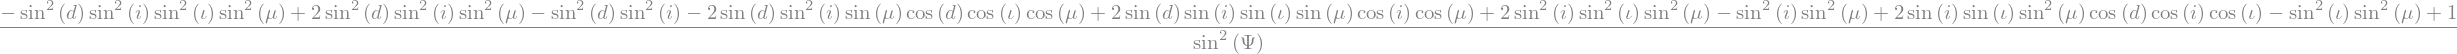

In [55]:
sp.simplify(sp.expand( sp.trigsimp(sin_zeta.obj)**2 + cos_zeta**2 ))

This is 1 if the numerator is equal to the denominator, and we have an explicit expression for $\cos(\Psi) = \sqrt{1 - \sin^2(\Psi)}$. So should get zero from the following:

In [56]:
zeta_check = sp.trigsimp(sp.numer(_) - (1-cosPsi**2))
assert zeta_check.equals(0)
display( zeta_check )

<IPython.core.display.Math object>

### The Shadow Length

We have the angle of the shadow vector $w$. Now find the length. Form $w(p) = g + p*s$ and enforce $w(p) \wedge G = 0$ (used $\lambda$ instead of $p$ in the paper but can't here because it's a keyword in Python).

In [57]:
G = e_frame(Gu)
display( ((g + p*s)^G) * I )

<IPython.core.display.Math object>

In [58]:
p_soln = sp.solve(sp.trigsimp(_.obj), p)[0]
display( p_soln )

AttributeError: 'Math' object has no attribute 'obj'

We can write this is in terms of the hour angle $\mu$ evaluated under the condition $\iota = \theta$ and denoted $\mu_s$. This is true when the gnomon is parallel to the earth's axis, and termed a style, hence the subscript $s$.

In [ ]:
mu_s = sp.Symbol(r"\mu_s")
D_soln = sin(Xi) * ((sin(i)*cos(d)*cos(theta)-cos(i)*sin(theta)) * cos(mu_s) - sin(i)*sin(d)*sin(mu_s)) + sin(alpha)*cos(sigma)*( sin(i)*sin(theta)*cos(d) + cos(i)*cos(theta) )
display( D_soln )

<IPython.core.display.Math object>

In [ ]:
# check
D_check = sp.simplify(sp.denom(p_soln) - D_soln.subs(mu_s,mu).subs(sin(mu),sinXi_sin_mu/sin(Xi)).subs(cos(mu),sinXi_cos_mu/sin(Xi)).subs(iota,theta))
assert D_check.equals(0)
display( D_check )

<IPython.core.display.Math object>

So given $p$, we have $w = g + ps$. However, it is a little cumbersome to work with and we can get $w$ in terms of $g$-$ps$-$w$ triangle directly by projecting $w$ onto $s$ and $g$ to give two equations we can solve for $p$ and $L$, the length of $w$. We have

$$s\cdot w = L\cos(\Xi-\beta) = s\cdot g + p\, s\cdot s = \cos(\Xi) + p$$

and

$$g\cdot w = L\cos(\beta) = g\cdot g + p g\cdot s = 1 + p\, \cos(\Xi)$$

This yields two simultaneous equations for $p$ and $L$, with solutions

$$p = \frac{\sin(\beta)}{\sin(\Xi-\beta)}$$

and

$$L = \frac{\sin(\Xi)}{\sin(\Xi-\beta)}$$

First define $w$ on the $n$ basis

In [ ]:
wu = gu + p*su
print_vec("w", wu, "u")

<IPython.core.display.Math object>

Then check that $p + \cos(\Xi)$ is equal to the projection of $w$ onto $s$

In [ ]:
ws_check = (su|wu) - (p + cosXi)
assert ws_check.obj.equals(0)
display( ws_check )

<IPython.core.display.Math object>

Now check that $1 + p\cos(\Xi)$ is equal to the projection of $w$ onto $g$

In [ ]:
wg_check = (gu|wu) - (1 + p*cosXi)
assert wg_check.obj.equals(0)
display( wg_check )

<IPython.core.display.Math object>

Given that $\sin(\beta)$ appears in the solution for $p$, it will be useful to have its explicit form, which is

In [ ]:
sin_beta = (sin(i)*sin(iota)*cos(d) + cos(i)*cos(iota))/sin(Psi)
print_eq(r"\sin(\beta)", sin_beta)

<IPython.core.display.Math object>

Confirm this by checking that $\sin^2(\beta) + \cos^2(\beta) - 1 = 0$

In [ ]:
cos_beta = sp.collect(sp.trigsimp((gu|what).obj), cos(mu))
print_eq(r"\cos(\beta)", cos_beta)

<IPython.core.display.Math object>

In [ ]:
beta_check = sp.trigsimp(sp.expand(sp.numer(sin_beta)**2 + sp.numer(cos_beta)**2) - (1-cosPsi**2))
assert beta_check.equals(0)
display( beta_check )

<IPython.core.display.Math object>

Give $\tan(\beta)$ as in the paper

In [ ]:
print_eq(r"\tan(\beta)", sin_beta/cos_beta)

<IPython.core.display.Math object>

We can now use the form of $p$ found by solving $w\wedge G = 0$ to obtain $\sin(\Xi)$. First note that $N$, the numerator of $p$, is related to $\beta$ via

$$\sin(\beta) = \frac{N}{\sin(\Psi)}$$

Check

In [ ]:
sin_beta_check = sp.numer(p_soln)/sin(Psi) - sin_beta
assert sin_beta_check.equals(0)
display( sin_beta_check )

<IPython.core.display.Math object>

Given our solution for $p$, we can write

$$p = \frac{\sin(\beta)}{\sin(\Xi-\beta)} = \frac{N}{D}$$

Eliminating $N$ using the above relationship with $\beta$ and solving for $D$ gives

$$D = \sin(\Psi)\sin(\Xi-\beta)$$

Note that using this to eliminate $\sin(\Xi-\beta)$ in our solution for $L$ gives

$$L = \frac{\sin(\Xi)\sin(\Psi)}{D}$$

Expanding the double angle in $D$ and solving for $\sin(\Xi)$ gives

$$\sin(\Xi) = \frac{D + N\cos(\Xi)}{B}$$

where

$$\cos(\beta) = \frac{B}{\sin(\Psi)}$$

Thus

In [ ]:
tmp = (sp.denom(p_soln) + sin(beta)*sin(Psi)*cos(Xi))/(cos(beta)*sin(Psi))
sinXi = tmp.subs(sin(beta),sin_beta).subs(cos(beta),cos_beta)
print_eq( r"\sin(\Xi)", sinXi)

<IPython.core.display.Math object>

### The Shadow Coordinates

Let's now get the cartesian coordinates of the shadow tip in the dial face frame.

$$w = L \hat{w}$$

and so can work with $\hat{w}$ and scale up by after.

In [ ]:
print_eq(r"\frac{x}{L}", what|m1)

<IPython.core.display.Math object>

In [ ]:
print_eq(r"\frac{y}{L}", mv.Mv(sp.trigsimp(sp.expand_trig((what|m2).obj)), ga=G3u))

<IPython.core.display.Math object>

In [ ]:
print_eq(r"\frac{z}{L}", what|m3)

<IPython.core.display.Math object>

Check:

In [59]:
assert (what|m1).obj.trigsimp().equals((-sin(d)*sin(mu)*cos(iota)+cos(d)*cos(mu))/sin(Psi))
assert (what|m2).obj.trigsimp().equals(-(sin(d)*cos(i)*cos(mu)+sin(i)*sin(iota)*sin(mu)+sin(mu)*cos(d)*cos(i)*cos(iota))/sin(Psi))
assert (what|m3).obj.trigsimp().equals(0)